# Create a Realistic Elliptical Galaxy with Multiple Photometry Component 

* The model is based on results from Huang et al. (2013a)

In [2]:
%matplotlib inline 
from __future__ import (division, print_function, absolute_import,
                        unicode_literals)

import os
import re
import json
import timeit
import warnings
import subprocess

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib.patches import Ellipse

# Numpy 
import numpy as np 
import numpy.random as rand

# Astropy
from astropy.io import fits

# GalSim
import galsim
print("# GalSim version : ", galsim.__version__)

# Numba
import numba 
from numba import jit
print("# Numba version : ", numba.__version__)

# PyMultiNest
import pymultinest
print("# PyMultiNest version : ", pymultinest.__path__)

# emcee 
import emcee 
print("# emcee version : ", emcee.__version__)

# PyMC3 
import pymc3 
print("# PyMC3 version : ", pymc3.__version__)

# Corner
import corner 
print("# Corner version : ", corner.__version__)

# Seaborn
import seaborn as sns
sns.set(color_codes=True)
print("# Seaborn version : ", sns.__version__)

# Color Map
from palettable.colorbrewer.qualitative import Set1_9 as compColor
try:
    cmap1 = plt.get_cmap('viridis')
    cmap1.set_bad('k', 1.)
    cmap2 = plt.get_cmap('inferno')
    cmap2.set_bad('w', 1.)
except Exception:
    from palettable.cubehelix import Cubehelix
    cmap1 = Cubehelix.make(start=0.3, rotation=-0.5,
                          reverse=True).mpl_colormap
    cmap1.set_bad('k', 1.)
    cmap2 = Cubehelix.make(start=0.5, rotation=-1.5,
                           gamma=1.0, sat=1.2,
                           min_light=0.,
                           max_light=1.).mpl_colormap
    cmap2.set_bad('w', 1.)

from palettable.colorbrewer.sequential import Greys_9, OrRd_9, Blues_9, Purples_9, YlGn_9
BLK = Greys_9.mpl_colormap
ORG = OrRd_9.mpl_colormap
BLU = Blues_9.mpl_colormap
GRN = YlGn_9.mpl_colormap
PUR = Purples_9.mpl_colormap

from palettable.colorbrewer.sequential import Greys_9_r, OrRd_9_r, Blues_9_r
BLK_r = Greys_9_r.mpl_colormap
ORG_r = OrRd_9_r.mpl_colormap
BLU_r = Blues_9_r.mpl_colormap

# GalSim version :  1.4
# Numba version :  0.27.0+0.g6ca78ce.dirty
# PyMultiNest version :  ['/Users/song/anaconda/lib/python2.7/site-packages/pymultinest']
# emcee version :  2.2.1
# PyMC3 version :  3.0
# Corner version :  2.0.2.dev0
# Seaborn version :  0.7.1


In [3]:
@jit(nopython=True, cache=True)
def zscale(img, contrast=0.25, samples=500):
    """
    Image scaling function.

    form http://hsca.ipmu.jp/hscsphinx/scripts/psfMosaic.html
    """
    ravel = img.ravel()
    ravel = ravel[np.isfinite(ravel)]

    if len(ravel) > samples:
        imsort = np.sort(np.random.choice(ravel, size=samples))
    else:
        imsort = np.sort(ravel)

    n = len(imsort)
    idx = np.arange(n)

    med = imsort[int(n / 2)]
    w = 0.25
    i_lo, i_hi = int((0.5 - w) * n), int((0.5 + w) * n)
    # BUG: Sometimes the polyfit could fail
    try:
        p = np.polyfit(idx[i_lo:i_hi], imsort[i_lo:i_hi], 1)
        slope, intercept = p
    except Exception:
        slope = 1.0

    z1 = med - (slope/contrast)*(n/2-n*w)
    z2 = med + (slope/contrast)*(n/2-n*w)

    return z1, z2

@jit(cache=True)
def singleSersic(xcen, ycen, flux, reff, nser, q, pa, 
                 nx, ny, psf=None, scale=1.0, exptime=1.0, 
                 trunc=0, max_fft=None):
    """Generate image for single Sersic component."""
    ser = galsim.Sersic(n=nser, half_light_radius=reff, 
                        flux=(flux * exptime), trunc=trunc).shear(
                        q=q, beta=(0.0 * galsim.degrees)).rotate(
                        (90.0 - pa) * galsim.degrees).shift(
                        (xcen - (nx / 2.0)), (ycen - (ny / 2.0)))
    
    if psf is not None: 
        if max_fft is not None:
            gsparams = galsim.GSParams(maximum_fft_size=max_fft) 
        else:
            gsparams = galsim.GSParams() 
        return (galsim.Convolve([ser, psf], 
                                gsparams=gsparams).drawImage(
                nx=nx, ny=ny, method='no_pixel', 
                scale=scale)).array
    else: 
        return (ser.drawImage(nx=nx, ny=ny, 
                              method='no_pixel', 
                              scale=scale)).array


    

@jit(cache=True)
def doubleSersic(xcen1, ycen1, flux1, reff1, nser1, q1, pa1, 
                 xcen2, ycen2, flux2, reff2, nser2, q2, pa2,
                 nx, ny, psf=None, scale=1.0, exptime=1.0, 
                 trunc=0, max_fft=None):
    """Generate image for double Sersic component."""
    ser = galsim.Add([galsim.Sersic(n=nser1, half_light_radius=reff1, 
                         flux=(flux1 * exptime), trunc=trunc).shear(
                         q=q1, beta=(0.0 * galsim.degrees)).rotate(
                         (90.0 - pa1) * galsim.degrees).shift(
                         (xcen1 - (nx / 2.0)), (ycen1 - (ny / 2.0))), 
                      galsim.Sersic(n=nser2, half_light_radius=reff2, 
                         flux=(flux2 * exptime), trunc=trunc).shear(
                         q=q2, beta=(0.0 * galsim.degrees)).rotate(
                         (90.0 - pa2) * galsim.degrees).shift(
                         (xcen2 - (nx / 2.0)), (ycen2 - (ny / 2.0)))])
    
    if psf is not None: 
        if max_fft is not None:
            gsparams = galsim.GSParams(maximum_fft_size=max_fft) 
            return (galsim.Convolve([ser, psf], 
                                    gsparams=gsparams).drawImage(
                    nx=nx, ny=ny, method='no_pixel', 
                    scale=scale)).array
        else:
            return (galsim.Convolve([ser, psf]).drawImage(
                    nx=nx, ny=ny, method='no_pixel', 
                    scale=scale)).array
    else: 
        return (ser.drawImage(nx=nx, ny=ny, 
                              method='no_pixel', 
                              scale=scale)).array


@jit(nopython=True, cache=True)
def loglike(model, data, sigma):
    """Get the log(Likelihood)."""
    return ((-0.5) * ((model - data) / sigma) ** 2).sum()

def loglike_old(model, data, sigma):
    """Get the log(Likelihood)."""
    return ((-0.5) * ((model - data) / sigma) ** 2).sum()

@jit(nopython=True, cache=True)
def logmad(model, data): 
    """
    Using MAD: Median absolute deviation.
    https://en.wikipedia.org/wiki/Median_absolute_deviation
    """
    return ((-0.5) * (1.4826 * np.nanmedian(np.abs((model - data) - np.nanmedian(model - data)))) ** 2)

def logmad_old(model, data): 
    """
    Using MAD: Median absolute deviation.
    https://en.wikipedia.org/wiki/Median_absolute_deviation
    """
    return ((-0.5) * (1.4826 * np.nanmedian(np.abs((model - data) - np.nanmedian(model - data)))) ** 2)

@jit(nopython=True, cache=True)
def mag2Flux(mag, zp, exptime):
    """Convert magnitude into flux"""
    return (10.0 ** ((zp - mag) / 2.5)) * exptime

def mag2Flux_old(mag, zp, exptime):
    """Convert magnitude into flux"""
    return (10.0 ** ((zp - mag) / 2.5)) * exptime

""" From Ben Johnson's Prospector: priors.py"""
def tophat(theta, mini=0.0, maxi=1.0, **extras):
    """
    A simple tophat function.  Input can be scalar or matched vectors
    """
    lnp = 1.0 * np.zeros_like(theta)
    n = (theta < mini) | (theta > maxi)
    lnp[n] = -np.infty
    return lnp

def normal(theta, mean=0.0, sigma=1.0, **extras):
    """
    A simple gaussian.  should make sure it can be vectorized.
    """
    return np.log((2*np.pi)**(-0.5)/sigma) - (theta - mean)**2/(2*sigma**2)

def quickFits(data, output='temp.fits'):
    hdu = fits.PrimaryHDU(data)
    hdulist = fits.HDUList([hdu])
    hdulist.writeto(output)

## Benchmark 

In [21]:
# With @jit
%timeit -n 1000 mag2Flux(23.0, 25.94, 100.0)

# Without @jit
%timeit -n 1000 mag2Flux_old(23.0, 25.94, 100.0)

The slowest run took 6.33 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 199 ns per loop
1000 loops, best of 3: 214 ns per loop


In [22]:
# Fake large 2-D array
mm = rand.random_sample([2000, 2000]) * 10.0
dd = rand.random_sample([2000, 2000]) * 10.0 
ss = rand.random_sample([2000, 2000]) * 0.5 

In [23]:
# With @jit
%timeit -n10 loglike(mm, dd, ss)

# Without @jit
%timeit -n10 loglike_old(mm, dd, ss)

10 loops, best of 3: 23.3 ms per loop
10 loops, best of 3: 41.2 ms per loop


In [15]:
# With @jit
%timeit -n10 logmad(mm, dd)

# Without @jit
%timeit -n10 logmad_old(mm, dd)

10 loops, best of 3: 140 ms per loop
10 loops, best of 3: 143 ms per loop


CPU times: user 8.76 ms, sys: 3.69 ms, total: 12.4 ms
Wall time: 11.8 ms


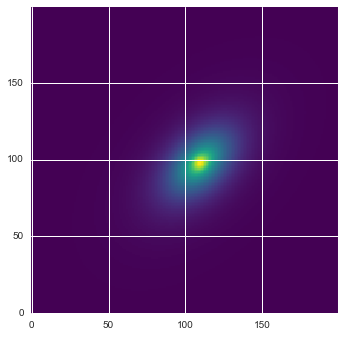

0.000836654 430.222


In [37]:
# Average situation, pretty easy
psf = galsim.Gaussian(fwhm=4.0)
exptime = 300.0

%time test = singleSersic(110.2, 98.4, mag2Flux(22.0, 27.0, 1.0), 5.00, 4.00, 0.60, 45.0, 200, 200, psf=psf, scale=1.0, exptime=exptime, trunc=0)

plt.imshow(np.arcsinh(test), origin='lower', cmap=cmap1, interpolation='none')
plt.show()

print(np.nanmin(test), np.nanmax(test))

CPU times: user 2.35 s, sys: 477 ms, total: 2.83 s
Wall time: 2.81 s


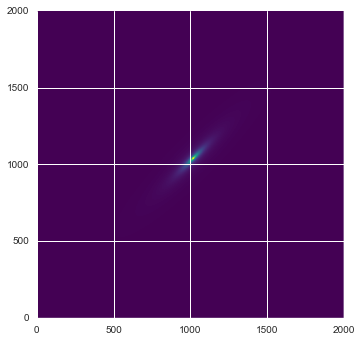

-2.66615e-05 19.6044


In [32]:
# Large image; high-Sersic index, large half-light radius; small axis ratio;
# Very challenging cases! 
%time test2 = singleSersic(1020.2, 1040.4, mag2Flux(22.0, 27.0, 1.0), 100.00, 6.00, 0.20, 45.0, 2000, 2000, max_fft=8192, trunc=1000, psf=psf, scale=1.0, exptime=exptime)

plt.imshow(np.arcsinh(test2), origin='lower', cmap=cmap1, interpolation='none')
plt.show()

print(np.nanmin(test2), np.nanmax(test2))

In [27]:
# Benchmark test 1  
# n=1.0; q=0.6; Should be quick
%timeit -n10 singleSersic(110.2, 98.4, mag2Flux(23.0, 27.0, 1.0), 5.00, 1.00, 0.60, 45.0, 200, 200, psf=psf, scale=1.0, exptime=exptime, trunc=0)

# Benchmark test 2
# n=4.0; q=0.3; Pretty slow... 
%timeit -n10 singleSersic(120.2, 120.4, mag2Flux(23.0, 27.0, 1.0), 5.00, 4.00, 0.30, 45.0, 200, 200, psf=psf, scale=1.0, exptime=exptime, trunc=0)

# Benchmark test 3
# n=6.0; q=0.2; reff=50; nx=1200; Super, super, super slow
%timeit -n10 singleSersic(620.2, 600.4, mag2Flux(22.0, 27.0, 1.0), 50.00, 6.00, 0.20, 45.0, 1200, 1200, trunc=600, psf=psf, scale=1.0, exptime=exptime)

10 loops, best of 3: 3.04 ms per loop
10 loops, best of 3: 26.9 ms per loop
10 loops, best of 3: 573 ms per loop


CPU times: user 35.3 ms, sys: 3.39 ms, total: 38.7 ms
Wall time: 38.7 ms


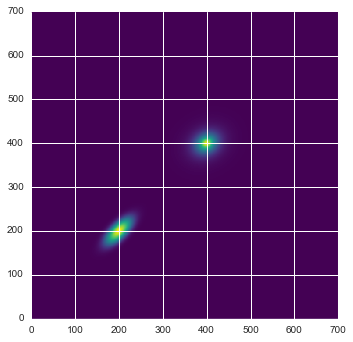

-2.10389e-05 87.3693


In [39]:
# Double Sersic
# Average situation, pretty easy
psf = galsim.Gaussian(fwhm=8.0)
exptime = 400.0

%time test3 = doubleSersic(200.2, 200.4, mag2Flux(22.0, 27.0, 1.0), 10.00, 1.00, 0.40, 45.0, \
                           400.2, 400.4, mag2Flux(22.5, 27.0, 1.0), 10.00, 2.50, 0.80, 60.0, \
                           700, 700, psf=psf, scale=1.0, \
                           exptime=exptime, trunc=0)

plt.imshow(np.arcsinh(test3), origin='lower', cmap=cmap1, interpolation='none')
plt.show()

print(np.nanmin(test3), np.nanmax(test3))

CPU times: user 610 ms, sys: 77.5 ms, total: 687 ms
Wall time: 685 ms


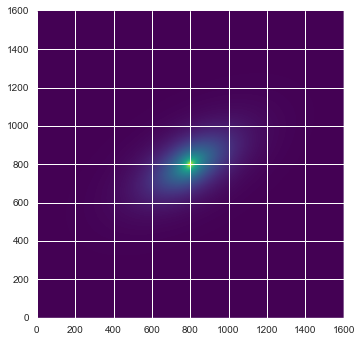

-7.22967e-05 405.889


In [41]:
# Double Sersic
# Difficult cases 
psf = galsim.Gaussian(fwhm=8.0)
exptime = 400.0

%time test4 = doubleSersic(800.2, 800.4, mag2Flux(20.0, 27.0, 1.0), 20.00, 2.50, 0.80, 45.0, \
                           800.2, 800.4, mag2Flux(19.5, 27.0, 1.0), 120.00, 1.50, 0.50, 60.0, \
                           1600, 1600, psf=psf, scale=1.0, \
                           exptime=exptime, trunc=850)

plt.imshow(np.arcsinh(test4), origin='lower', cmap=cmap1, interpolation='none')
plt.show()

print(np.nanmin(test4), np.nanmax(test4))

In [43]:
%timeit -n10 test5 = doubleSersic(350.2, 350.4, mag2Flux(22.0, 27.0, 1.0), 10.00, 2.00, 0.80, 45.0, \
                                  350.2, 350.4, mag2Flux(22.5, 27.0, 1.0), 20.00, 1.00, 0.40, 60.0, \
                                  700, 700, psf=psf, scale=1.0, \
                                  exptime=exptime, trunc=0)

%timeit -n10 test6 = doubleSersic(700.2, 700.4, mag2Flux(20.0, 27.0, 1.0), 30.00, 2.50, 0.80, 45.0, \
                                  700.2, 700.4, mag2Flux(20.5, 27.0, 1.0), 80.00, 2.00, 0.50, 30.0, \
                                  1400, 1400, psf=psf, scale=1.0, \
                                  exptime=exptime, trunc=750)

10 loops, best of 3: 35 ms per loop
10 loops, best of 3: 262 ms per loop


# Task 1 : Single Sersic model + Central Offsets + No Sky 

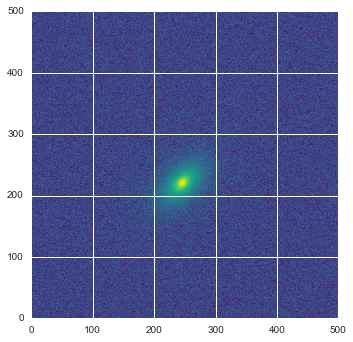

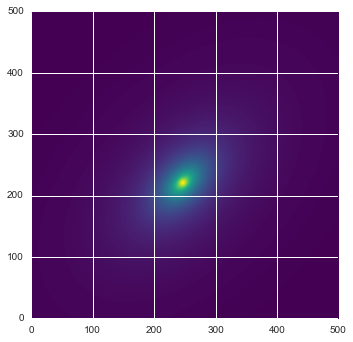

-2.58058453892 309.593693592
0.0187234 17.5913


In [24]:
#=============================================================================#

# Observation related parameter
im_size = 500 
nx, ny = 500, 500
pix_scale = 1.0 
zp = 27.0 
exptime = 240.0

# Test model
xcen_true = 246.6
ycen_true = 221.4
mag_true = 21.0
reff_true = 10.0
nser_true = 4.0 
q_true = 0.6
pa_true = 45.0

truths = [xcen_true, ycen_true, mag_true, reff_true, nser_true, q_true, pa_true]

#=============================================================================#

# PSF model
psf = galsim.Gaussian(fwhm=6.0)

# Sersic galaxy model
galaxy = singleSersic(xcen_true, ycen_true, 
                      mag2Flux(mag_true, zp, 1.0), reff_true, 
                      nser_true, q_true, pa_true, 
                      nx, ny, psf=psf, scale=pix_scale, 
                      exptime=exptime)

# Image with noise
data = galaxy + np.random.normal(0.0, 0.5, [im_size, im_size])

plt.imshow(np.arcsinh(data), origin='lower', cmap=cmap1, interpolation='none')
plt.show()

# Sigma image
sigma = np.sqrt(galaxy) + 1e-3

plt.imshow(np.arcsinh(sigma), origin='lower', cmap=cmap1)
plt.show()

## Min, Max
print(np.min(data), np.max(data))
print(np.min(sigma), np.max(sigma))

## MultiNest Test

### Setup the model, priors, and the log(Likelihood) functions

In [25]:
# Number of free parameters in single Sersic model 
parameters = ["xcen", "ycen", "mag", "reff", "nser", "q", "pa"]

labels = [r'$\mathrm{X0}$', r'$\mathrm{Y0}$',
          r'$\mathrm{mag}$', r'$\mathrm{R}_{e}$', r'$\mathrm{n}_{\mathrm{Ser}}$', 
          r'$\mathrm{b}/\mathrm{a}$', r'$\mathrm{PA}$']

n_params = len(parameters)

# Model 
def model(xcen, ycen, mag, reff, nser, q, pa,
          nx=64, ny=64, scale=1.0, 
          psf=None, zp=25.94, exptime=None,
          trunc=0, max_fft=None):
    """Single Sersic model."""
    try:
        return singleSersic(xcen, ycen, mag2Flux(mag, zp, 1.0), 
                            reff, nser, q, pa, 
                            nx, ny, psf=psf, 
                            scale=pix_scale,
                            exptime=exptime,
                            trunc=trunc, max_fft=max_fft)
    except RuntimeError:
        return singleSersic(xcen, ycen, mag2Flux(mag, zp, 1.0), 
                            reff, nser, q, pa, 
                            nx, ny, psf=psf, 
                            scale=pix_scale,
                            exptime=exptime,
                            trunc=(int((nx / 2.0) * 1.1)), 
                            max_fft=8196)

    
# Priors
# Start test with broad, flat distributions
def priors(cube, n_dim, n_params):
    """Priors for single Sersic models."""
    # X Center 
    cenWindow = 100
    cube[0] = cube[0] * cenWindow + ((nx - cenWindow) / 2.0)
    # Y Center 
    cube[1] = cube[1] * cenWindow + ((ny - cenWindow) / 2.0)
    # Magnitude
    cube[2] = cube[2] * 7.0 + 18.0
    # Effective radius
    cube[3] = cube[3] * 50.0 + 0.5 
    # Sersic index
    cube[4] = cube[4] * 5.5 + 0.5
    # Axie ratio  
    cube[5] = cube[5] * 0.95 + 0.05
    # Position angle
    cube[6] = cube[6] * 180.0
    
    
# Log Likelihood
def loglikelihood(cube, n_dim, n_params):
    """Log(Likelihood)."""
    xcen, ycen, mag = cube[0], cube[1], cube[2] 
    reff, nser, q, pa = cube[3], cube[4], cube[5], cube[6]
    
    return loglike(model(xcen, ycen, mag, 
                         reff, nser, q, pa,
                         nx=nx, 
                         ny=ny, 
                         scale=pix_scale, 
                         psf=psf, 
                         zp=zp, 
                         exptime=exptime), 
                   data, sigma)

### Benchmark for model generation and likelihood evaluation

In [26]:
%timeit -n100 model(240.0, 240.0, 21.5, 8.0, 4.0, 0.4, 45.0, \
                    nx=nx, ny=ny, scale=pix_scale, \
                    psf=psf, zp=zp, exptime=exptime)

100 loops, best of 3: 25.8 ms per loop


In [51]:
%timeit -n100 loglike(model(240.0, 240.0, 21.2, 10.0, 4.0, 0.4, 45.0, \
                            nx=nx, ny=ny, scale=pix_scale, \
                            psf=psf, zp=zp, exptime=exptime), data, sigma)

100 loops, best of 3: 53.1 ms per loop


### Start the MultiNest run

In [ ]:
# Run multinest
%time pymultinest.run(loglikelihood, priors, n_params, \
                      outputfiles_basename='sersic_test_2_', \
                      importance_nested_sampling=True, \
                      const_efficiency_mode=False, \
                      n_live_points=400, \
                      evidence_tolerance=0.5, \
                      sampling_efficiency=0.8, \
                      n_iter_before_update=100, \
                      null_log_evidence=-1e+90, \
                      max_modes=100, \
                      mode_tolerance=-1e+90, \
                      max_iter=0, \
                      init_MPI=True, \
                      resume=False, \
                      verbose=True)

# Dump the parameter names 
json.dump(parameters, open('sersic_test_2_params.json', 'w'))

### Analysis the results

  analysing data from sersic_test_2_.txt


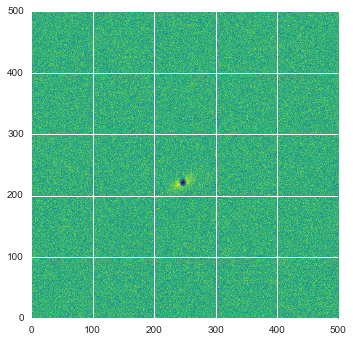

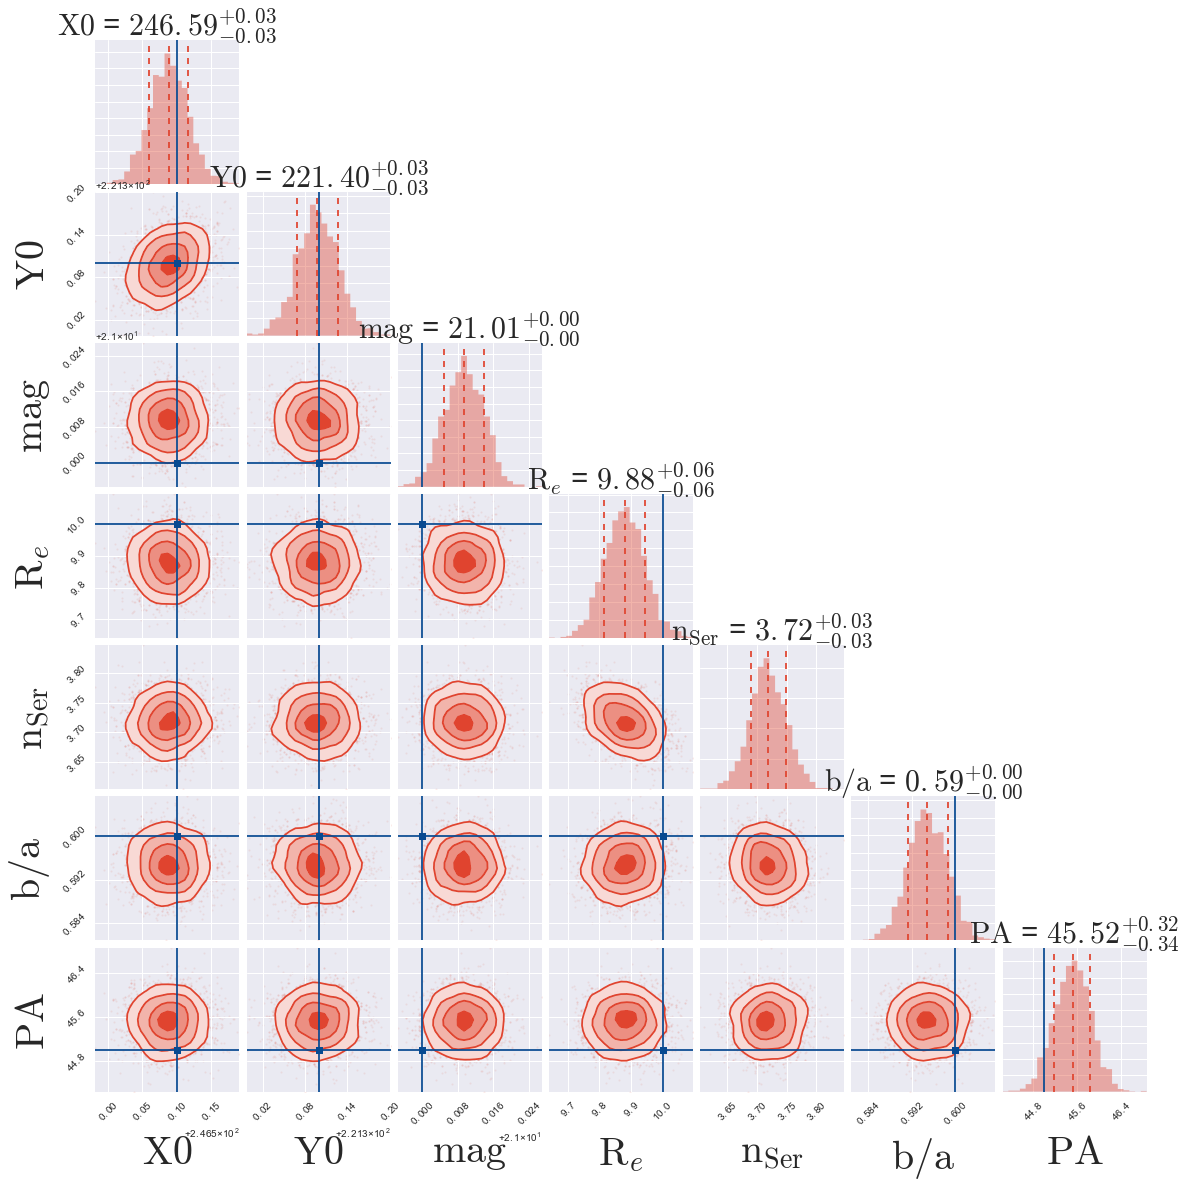

In [29]:
# Load in the results
res = pymultinest.Analyzer(outputfiles_basename='sersic_test_2_', 
                           n_params = n_params)

# Best parameters
bestP = res.get_best_fit()['parameters']

# Get the best models
bestM = singleSersic(bestP[0], bestP[1], 
                     mag2Flux(bestP[2], zp, 1.0), bestP[3], bestP[4], 
                     bestP[5], bestP[6], im_size, im_size, 
                     psf=psf, scale=pix_scale, exptime=exptime)

# Show the residual
plt.imshow(np.arcsinh(bestM - data), origin='lower', cmap=cmap1)
plt.show()

#-----------------------------------------------------------------#
# Parameters:
# bins: number of bins for histograms 
# color: color of the histograms
# smooth: Gaussian kernel to smooth the 2-D histograms
# truths: list of "truths" or best estimated values
# truth_color: color to highlight the "truths"
# labels: labels for each dimension
# quantiles: percentiles of the results to highlight
# show_titles: whether to show the results 
# plot_contours: whether to plot contours in dense region
# fill_contours: whether to color-fill the contours (looks pretty) 
fig1 = corner.corner(res.get_equal_weighted_posterior()[:,0:7],
                     bins=25,
                     color=ORG(0.7),
                     smooth=1,
                     truths=truths,
                     truth_color=BLU(0.9),
                     labels=labels,
                     label_kwargs={'fontsize':40},
                     quantiles=[0.16, 0.5, 0.84],
                     plot_contours=True,
                     fill_contours=True,
                     show_titles=True, 
                     title_kwargs={"fontsize": 30},
                     hist_kwargs={"histtype": 'stepfilled', 
                                  "alpha": 0.4, 
                                  "edgecolor": "none"},
                     use_math_text=True)

# Make the figure larger for output
fig1.set_size_inches(16.0, 16.0)

# Save the figure 
#fig1.savefig('alf_corner_example_1b.png', dpi=220)

# Task 2 : Double Sersic model + Common Central Offsets + No Sky 

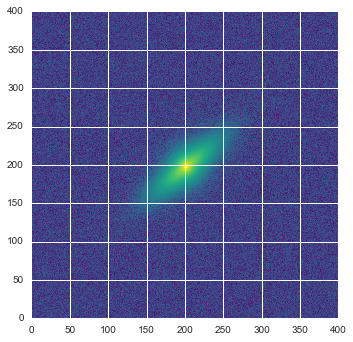

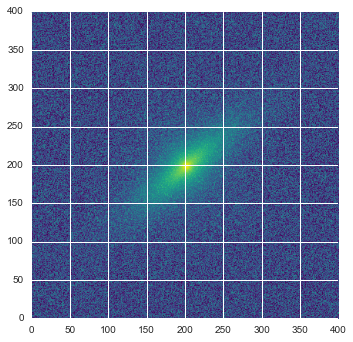

-2.69182061558 777.190148419
0.00372075674455 29.8636685363


In [4]:
#=============================================================================#

# Observation related parameter
im_size = 400 
nx, ny = 400, 400
pix_scale = 1.0 
zp = 27.0 
exptime = 250.0

# Test model
xcen_true = 202.0
ycen_true = 198.5

mag1_true = 21.0
reff1_true = 6.0
nser1_true = 2.6 
q1_true = 0.9
pa1_true = 10.0

mag2_true = 20.5
reff2_true = 14.0
nser2_true = 1.2 
q2_true = 0.3
pa2_true = 50.0

truths = [xcen_true, ycen_true, 
          mag1_true, reff1_true, nser1_true, q1_true, pa1_true,
          mag2_true, reff2_true, nser2_true, q2_true, pa2_true]

#=============================================================================#

# PSF model
psf = galsim.Gaussian(fwhm=4.5)

# Sersic galaxy model
galaxy = doubleSersic(xcen_true, ycen_true, 
                      mag2Flux(mag1_true, zp, 1.0), reff1_true, 
                      nser1_true, q1_true, pa1_true, 
                      xcen_true, ycen_true,
                      mag2Flux(mag2_true, zp, 1.0), reff2_true, 
                      nser2_true, q2_true, pa2_true, 
                      nx, ny, psf=psf, scale=pix_scale, 
                      exptime=exptime)

# Image with noise
data = galaxy + np.random.normal(0.0, 0.6, [nx, ny])

plt.imshow(np.arcsinh(data), origin='lower', cmap=cmap1, interpolation='none')
plt.show()

# Sigma image
sigma = np.sqrt(galaxy) + np.abs(np.random.normal(0.1, 1.5, [nx, ny]))

plt.imshow(np.arcsinh(sigma), origin='lower', cmap=cmap1)
plt.show()

## Min, Max
print(np.min(data), np.max(data))
print(np.min(sigma), np.max(sigma))

## MultiNest Test

### Setup the model, priors, and the log(Likelihood) functions

In [27]:
# Number of free parameters in single Sersic model 
parameters = ["xcen", "ycen", 
              "mag1", "reff1", "nser1", "q1", "pa1",
              "mag2", "reff2", "nser2", "q2", "pa2"]

labels = [r'$\mathrm{X0}$', r'$\mathrm{Y0}$',
          r'$\mathrm{mag_{1}}$', r'$\mathrm{R}_{e,1}$', r'$\mathrm{n}_{\mathrm{Ser,1}}$', 
          r'${\mathrm{b}/\mathrm{a}}_{1}$', r'$\mathrm{PA_{1}}$',
          r'$\mathrm{mag_{2}}$', r'$\mathrm{R}_{e,2}$', r'$\mathrm{n}_{\mathrm{Ser,2}}$', 
          r'${\mathrm{b}/\mathrm{a}}_{2}$', r'$\mathrm{PA_{2}}$']

n_params = len(parameters)

# Model 
def model(xcen, ycen, 
          mag1, reff1, nser1, q1, pa1,
          mag2, reff2, nser2, q2, pa2,
          nx=64, ny=64, scale=1.0, 
          psf=None, zp=25.94, exptime=None,
          trunc=0, max_fft=None):
    """Single Sersic model."""
    try:
        return doubleSersic(xcen, ycen, 
                            mag2Flux(mag1, zp, 1.0), 
                            reff1, nser1, q1, pa1, 
                            xcen, ycen,
                            mag2Flux(mag2, zp, 1.0), 
                            reff2, nser2, q2, pa2, 
                            nx, ny, psf=psf, 
                            scale=pix_scale,
                            exptime=exptime,
                            trunc=trunc, 
                            max_fft=max_fft)
    except RuntimeError:
        try:
            return doubleSersic(xcen, ycen, 
                                mag2Flux(mag1, zp, 1.0), 
                                reff1, nser1, q1, pa1, 
                                xcen, ycen,
                                mag2Flux(mag2, zp, 1.0), 
                                reff2, nser2, q2, pa2, 
                                nx, ny, psf=psf, 
                                scale=pix_scale,
                                exptime=exptime,
                                max_fft=8196)
        except RuntimeError:
            return doubleSersic(xcen, ycen, 
                                mag2Flux(mag1, zp, 1.0), 
                                reff1, nser1, q1, pa1, 
                                xcen, ycen,
                                mag2Flux(mag2, zp, 1.0), 
                                reff2, nser2, q2, pa2, 
                                nx, ny, psf=psf, 
                                scale=pix_scale,
                                exptime=exptime,
                                trunc=(int((nx / 2.0) + 1)), 
                                max_fft=8196)

    
# Priors
# Start test with broad, flat distributions
def priors(cube, n_dim, n_params):
    """Priors for single Sersic models."""
    # X Center 
    cenWindow = 40
    cube[0] = cube[0] * cenWindow + ((nx - cenWindow) / 2.0)
    # Y Center 
    cube[1] = cube[1] * cenWindow + ((ny - cenWindow) / 2.0)
    
    # Magnitude 1
    cube[2] = cube[2] * 6.0 + 18.0
    # Effective radius 1
    cube[3] = cube[3] * 50.0 + 0.5 
    # Sersic index 1
    cube[4] = cube[4] * 5.5 + 0.5
    # Axie ratio 1
    cube[5] = cube[5] * 0.90 + 0.10
    # Position angle 1
    cube[6] = cube[6] * 180.0
    
    # Magnitude 2
    cube[7] = cube[7] * 6.0 + 18.0
    # Effective radius 2
    cube[8] = cube[8] * 50.0 + 0.5 
    # Sersic index 2
    cube[9] = cube[9] * 5.5 + 0.5
    # Axie ratio 2
    cube[10] = cube[10] * 0.90 + 0.10
    # Position angle 2
    cube[11] = cube[11] * 180.0
    
    
# Log Likelihood
def loglikelihood(cube, n_dim, n_params):
    """Log(Likelihood)."""
    xcen, ycen = cube[0], cube[1]
    mag1, reff1, nser1, q1, pa1 = cube[2], cube[3], cube[4], cube[5], cube[6]
    mag2, reff2, nser2, q2, pa2 = cube[7], cube[8], cube[9], cube[10], cube[11]
    
    try:
        return loglike(model(xcen, ycen, 
                             mag1, reff1, nser1, q1, pa1,
                             mag2, reff2, nser2, q2, pa2,
                             nx=nx, 
                             ny=ny, 
                             scale=pix_scale, 
                             psf=psf, 
                             zp=zp, 
                             exptime=exptime), 
                       data, sigma)
    except Exception:
        print("#1 ", mag1, reff1, nser1, q1, pa1)
        print("#2 ", mag2, reff2, nser2, q2, pa2, "\n")
        return -np.inf

### Benchmark for model generation and likelihood evaluation

In [49]:
%timeit -n20 model(200.1, 201.5, \
                   22.5, 20.0, 4.0, 0.3, 45.0, \
                   21.5, 30.0, 2.5, 0.2, 45.0, \
                   nx=nx, ny=ny, scale=pix_scale, \
                   psf=psf, zp=zp, exptime=exptime)

20 loops, best of 3: 306 ms per loop


In [51]:
%timeit -n20 loglike(model(200.1, 201.5, \
                           22.5, 20.0, 4.0, 0.3, 45.0, \
                           21.5, 30.0, 2.5, 0.2, 45.0, \
                           nx=nx, ny=ny, scale=pix_scale, \
                           psf=psf, zp=zp, exptime=exptime), \
                     data, sigma)

20 loops, best of 3: 303 ms per loop


### Start the MultiNest run

In [ ]:
# Run multinest
%time pymultinest.run(loglikelihood, priors, n_params, \
                      outputfiles_basename='sersic_test_3_', \
                      importance_nested_sampling=True, \
                      const_efficiency_mode=False, \
                      n_live_points=600, \
                      evidence_tolerance=0.5, \
                      sampling_efficiency=0.8, \
                      n_iter_before_update=100, \
                      null_log_evidence=-1e+90, \
                      max_modes=100, \
                      mode_tolerance=-1e+90, \
                      max_iter=0, \
                      init_MPI=True, \
                      resume=False, \
                      verbose=True)

# Dump the parameter names 
json.dump(parameters, open('sersic_test_3_params.json', 'w'))

In [24]:
doubleSersic(200.1, 201.5, 
             19.3655827045, 38.9507864714, 5.76210945845, 0.851795291901, 65.2400887012,
             200.1, 201.5,
             19.7949407101, 5.85907149315, 0.730187952518, 0.207658827305, 171.510626078,
             nx, ny, psf=psf, scale=1.0, exptime=300.0, 
             trunc=0, max_fft=8192)

array([[ 0.00166477,  0.00167465,  0.00168458, ...,  0.00120904,
         0.00120158,  0.00119418],
       [ 0.00167746,  0.00168748,  0.00169755, ...,  0.00121832,
         0.00121077,  0.00120328],
       [ 0.00169025,  0.0017004 ,  0.00171061, ...,  0.00122768,
         0.00122004,  0.00121245],
       ..., 
       [ 0.00123886,  0.00124671,  0.00125462, ...,  0.00175248,
         0.00174184,  0.00173125],
       [ 0.00122948,  0.00123724,  0.00124505, ...,  0.00173911,
         0.00172861,  0.00171817],
       [ 0.00122017,  0.00122784,  0.00123556, ...,  0.00172583,
         0.00171548,  0.00170518]], dtype=float32)